In [1]:
import numpy as np 
import pandas as pd 
import numpy.linalg as la 
import numpy.matlib
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')


In [62]:
class UniversalApprox:
    def __init__(self, epsilon = 0.01, fun = None): 
        #epsilon smaller, more intervals, better approximation on original function
        self.epsilon = epsilon
        if fun == None: # have a default target function in the class
            self.fun = self.wiggles_fun
        else:
            self.fun = fun
                
    def wiggles_fun(self, t): #default target function
        r = np.sin(5*t)*np.exp(t)
        return r
    
    def sigmoid(self, x, a, b):
        # a increase => sigmoid slope increase
        # b increase => sigmoid moves to the left
        part2_1 = (x-b)/a #b is bias, and a is weight
        part2 = np.exp(-part2_1)
        s = 1/(1+part2)
        return s
    
    def solve_ab(self, x, y):
        #When constructing sigmoid, we need to solve a, b given x_pair, y_pair
        # solve a,b by matrix [a,b] = [A]^-1 * [x0,x1]
        l_0 = y[0]/(1-y[0])
        l_1 = y[1]/(1-y[1])
        A = np.array([[np.log(l_0), 1], [np.log(l_1), 1]])
        x_vec = np.array([x[0], x[1]])
        ab = np.linalg.inv(A) @ x_vec
        return ab #np.array([a,b])
        
    def find_nn_params(self, t_in, fun, j_ext = 10):
    ## want to generate all sigmoids params based on x and y
    ## for the neural network
    
    # 1. since the subtraction of 2 sigmoid functions results
    # in a bump function with tails. We want to extend the support
        t_ext = np.linspace(t_in[0]-t_in[j_ext], t_in[-1]+(t_in[j_ext] - t_in[0]), t_in.shape[0]+int(2*j_ext))
    # since the LHS and RHS extended j_ext number of points. the linspace num should plus 2*j_ext
    
    #2. find the sigmoid parameters
        delta = t_in[1] - t_in[0]
        n = t_ext.shape[0]
        ab_matrix = np.zeros([n,2])
        for idx, entry in enumerate(t_ext):
            x_pair = np.array([t_ext[idx], t_ext[idx] - delta/2])
            y_pair = np.array([1-(self.epsilon/2), 0.5])
            ab = self.solve_ab(x_pair, y_pair)
            ab_matrix[idx,:] = ab.flatten() #ab matrix: each row is [a,b]
        
    #3. find the actual samples  
        samples = fun(t_ext)
        return t_ext, samples, ab_matrix
    
    def approx_fun(self, t_in, fun, j_ext = 10, t_eval = None): 
        #t_eval: when we want to replace existing t_ext
        #After having all sigmoids, we now in process to create bumps
        
        #1. start
        t_ext, samples, ab_matrix = self.find_nn_params(t_in, fun, j_ext = 10)
        #1.1 replace t_ext
        if t_ext is not None:
            t_ext = t_eval
        
        #2. initial set up 
        # y be the approxmation from the sigmoids (sum(bumps))
        # y_total be a matrix where each row records the y_value of that bump function
        n = samples.shape[0]
        y = np.zeros(t_ext.shape[0])
        y_total = np.zeros([t_ext.shape[0],samples.shape[0]])
        

        
        for i in range(n-1): 
            s = samples[i]
            sig_a_1 = ab_matrix[i,0] #sigmoid(self, x, a, b)
            sig_b_1= ab_matrix[i,1]
            sig_a_2 = ab_matrix[i+1,0]
            sig_b_2 = ab_matrix[i+1,1]
            #original bump is obtained by subtracting 2 sigmoids
            original_bump = self.sigmoid(t_ext, sig_a_1, sig_b_1) - self.sigmoid(t_ext, sig_a_2, sig_b_2)
            bump = s * original_bump
            y_total[:,i] = bump
            y = y + bump
            
        return t_ext, y, y_total
  

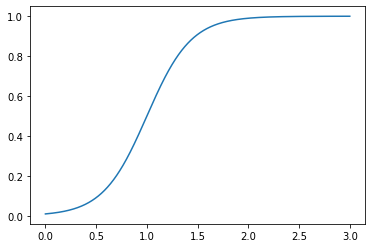

In [63]:
eps = 0.01
ua = UniversalApprox(epsilon = eps)
t_space = np.linspace(0,3,60)
t_ext = np.linspace(0,3,2500)
x_points = np.array([0,2])
y_points = np.array([eps,1-eps])
ab = ua.solve_ab(x_points,y_points)
sigm = ua.sigmoid(t_ext,ab[0],ab[1])
plt.figure(0)
plt.plot(t_ext,sigm)

In [64]:
t_eval, y_approx,y_incs  = ua.approx_fun(t_space,ua.wiggles_fun,t_eval = t_ext)


In [65]:
y_truth = ua.fun(t_eval)

In [66]:
y_err = y_truth - y_approx

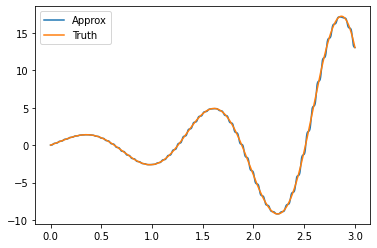

In [67]:
plt.figure(1)
plt.plot(t_eval, y_approx, label = 'Approx')
plt.plot(t_eval, y_truth, label = 'Truth')
plt.legend()

Text(0, 0.5, 'err')

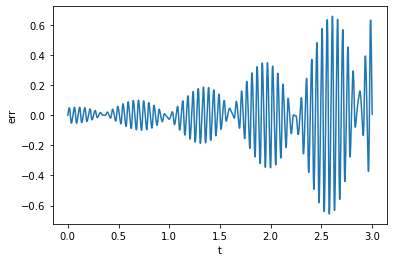

In [68]:
plt.plot(t_eval,y_err)
plt.xlabel('t')
plt.ylabel('err')

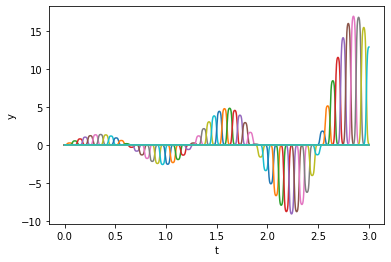

In [69]:
for j in range(y_incs.shape[1]):
    plt.plot(t_eval,y_incs[:,j])
    plt.xlabel('t')
    plt.ylabel('y')

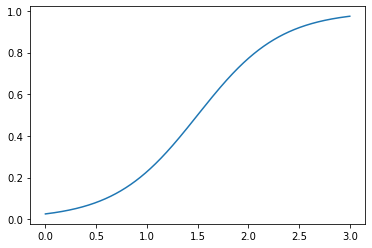

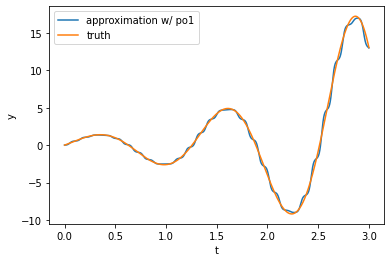

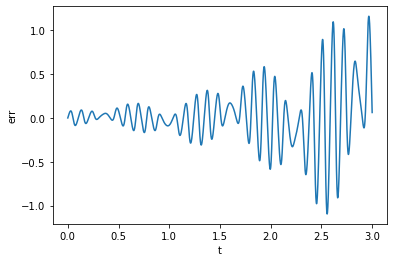

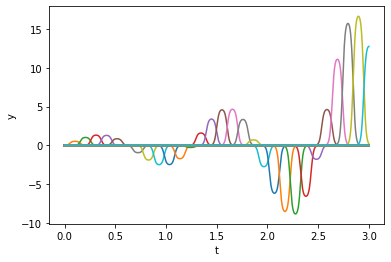

In [70]:
import numpy as np 
import pandas as pd 
import numpy.linalg as la 
import numpy.matlib
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

class UniversalApprox:
    def __init__(self, epsilon = 0.01, fun = None): 
        #epsilon is used to obtain the upper y value 
        self.epsilon = epsilon
        if fun == None: # have a default target function in the class
            self.fun = self.wiggles_fun
        else:
            self.fun = fun

    def wiggles_fun(self, t): #default target function
        r = np.sin(5*t)*np.exp(t)
        return r

    def sigmoid(self, x, a=1, b=0):
        # a increase => sigmoid slope increase
        # b increase => sigmoid moves to the left
        part2_1 = (x-b)/a #b is bias, and a is weight
        part2 = np.exp(-part2_1)
        s = 1/(1+part2)
        return s

    def solve_ab(self, x, y):
        #When constructing sigmoid, we need to solve a, b given x_pair, y_pair
        # solve a,b by matrix [a,b] = [A]^-1 * [x0,x1]
        l_0 = y[0]/(1-y[0])
        l_1 = y[1]/(1-y[1])
        A = np.array([[np.log(l_0), 1], [np.log(l_1), 1]])
        x_vec = np.array([x[0], x[1]])
        ab = np.linalg.inv(A) @ x_vec
        return ab #np.array([a,b])

    def find_nn_params(self, t_in, fun, j_ext = 10):
    ## want to generate all sigmoids params based on x and y
    ## for the neural network
    
    # 1. since the subtraction of 2 sigmoid functions results
    # in a bump function with tails. We want to extend the support
        t_ext = np.linspace(t_in[0]-t_in[j_ext], t_in[-1]+(t_in[j_ext] - t_in[0]), t_in.shape[0]+int(2*j_ext))
    # since the LHS and RHS extended j_ext number of points. the linspace num should plus 2*j_ext spaces
    # each space is consistent as before
    
    #2. find the sigmoid parameters
        delta = t_in[1] - t_in[0] #just a parameter for solving sigmoid
        n = t_ext.shape[0]
        ab_matrix = np.zeros([n,2]) #ab matrix: each row is [a,b]
        for idx, entry in enumerate(t_ext):
            x_pair = np.array([t_ext[idx], t_ext[idx] - delta/2])
            y_pair = np.array([1-(self.epsilon/2), 0.5])
            ab = self.solve_ab(x_pair, y_pair)
            ab_matrix[idx,:] = ab.flatten() #ab matrix: each row is [a,b]
        
    #3. find the actual samples  
        samples = fun(t_ext)
        return t_ext, samples, ab_matrix

            
    def approx_fun(self, t_in, fun, j_ext = 10, t_eval = None): 
        #t_eval: when we want to replace existing t_ext
        #After having all sigmoids, we now in process to create bumps
        
        #1. start
        t_ext, samples, ab_matrix = self.find_nn_params(t_in, fun, j_ext = 10)
        #1.1 replace t_ext
        if t_ext is not None:
            t_ext = t_eval
        
        #2. initial set up 
        # y be the approxmation from the sigmoids (sum(bumps))
        # y_total be a matrix where each row records the y_value of that bump function
        n = samples.shape[0]
        y = np.zeros(t_ext.shape[0])
        y_total = np.zeros([t_ext.shape[0],samples.shape[0]])
        

        
        for i in range(n-1): 
            s = samples[i]
            sig_a_1 = ab_matrix[i,0] #sigmoid(self, x, a, b)
            sig_b_1= ab_matrix[i,1]
            sig_a_2 = ab_matrix[i+1,0]
            sig_b_2 = ab_matrix[i+1,1]
            #original bump is obtained by subtracting 2 sigmoids
            original_bump = self.sigmoid(t_ext, sig_a_1, sig_b_1) - self.sigmoid(t_ext, sig_a_2, sig_b_2)
            bump = s * original_bump
            y_total[:,i] = bump
            y = y + bump
            
        return t_ext, y, y_total

if __name__ == "__main__":
    plotting = True
    eps = .025
    ## Step 1: instantiate your UniversalApprox Object
    ua = UniversalApprox(epsilon = eps)

    ### Step 2: Generate approximations with po1
    ## If you use my wiggles_fun, it has an exp, so don't go wild on your domain
    # need sample linspace for function approximation, and denser linspace for evaluation
    x_lim = 3
    t_space = np.linspace(0,x_lim,30)
    t_dense = np.linspace(0,x_lim,2500)

    ###2.a: check the a,b solve
    x_points = np.array([0,3])
    y_points = np.array([eps,1-eps])
    ab = ua.solve_ab(x_points,y_points)
    sigm = ua.sigmoid(t_dense,ab[0],ab[1])
    plt.figure(0)
    plt.plot(t_dense,sigm)

    t_eval, y_approx,y_incs  = ua.approx_fun(t_space,ua.wiggles_fun,t_eval = t_dense)
    y_truth = ua.fun(t_eval)
    y_err = y_truth - y_approx
    if plotting: 
        plt.figure(1)
        plt.plot(t_eval,y_approx,label = 'approximation w/ po1')
        plt.plot(t_eval,y_truth, label = 'truth')
        plt.legend()
        plt.xlabel('t')
        plt.ylabel('y')
        plt.figure(2)
        plt.plot(t_eval,y_err)
        plt.xlabel('t')
        plt.ylabel('err')
        plt.figure(3)
        for j in range(y_incs.shape[1]):
            plt.plot(t_eval,y_incs[:,j])
        plt.xlabel('t')
        plt.ylabel('y')